In [ ]:
!pip install catboost==1.2.3 numpy==1.26.4

# Ансамбли

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

In [ ]:
import numpy as np
import pandas as pd

## Регрессия

In [ ]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

In [ ]:
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['target'] = data['target']

In [ ]:
display(df.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
features = data['feature_names']
target = 'target'

In [ ]:
features

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Подготовим выборки для обучения

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=41)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
# Функция рассчёта регрессионных метрик по которым будем сравнивать модели
def check_metrics(y_true, y_preds):

  r2 = round(r2_score(y_true, y_preds), 3)
  mse = round(mean_squared_error(y_true, y_preds), 3)
  spearman =  round(spearmanr(y_true, y_preds)[0], 3)

  print('Unique Predicts:', len(set(y_preds)))
  print('R2:', r2)
  print('MSE:', mse)
  print('Spearman:', spearman)

  return r2, mse, spearman

In [ ]:
# Вспомогательная функция для фита и рассчёта метрик

global_regression_results = {}

def fit_regression(reg, name):
  global global_regression_results

  reg.fit(X_train.values, y_train.values)
  predict_train = reg.predict(X_train.values)
  predict_test = reg.predict(X_test.values)
  print('Train:')
  train_r2, train_mse, train_spearman = check_metrics(y_train, predict_train)
  print()
  print('Test:')
  test_r2, test_mse, test_spearman = check_metrics(y_test, predict_test)

  global_regression_results[name] = {
      # Train
      'train_r2': train_r2,
      'train_mse': train_mse,
      'train_spearman': train_spearman,
      # Test
      'test_r2': test_r2,
      'test_mse': test_mse,
      'test_spearman': test_spearman,
  }

### Обычное дерево

In [ ]:
# Test:
# R2: 0.628
# MSE: 0.493
# Spearman: 0.846

In [ ]:
tree = DecisionTreeRegressor(max_depth=8)
fit_regression(tree, 'tree')

Train:
Unique Predicts: 232
R2: 0.769
MSE: 0.308
Spearman: 0.867

Test:
Unique Predicts: 194
R2: 0.71
MSE: 0.384
Spearman: 0.843


### Случайный Лес (ручной)

In [ ]:
from tqdm.auto import tqdm

class MyRandomForestRegressor:
  def __init__(self, num_trees=10, max_depth=5):
    self.num_trees = num_trees
    self.max_depth = max_depth

  def fit(self, X, y):
    # Создаем массив деревьев куда будем складывать обученные деревья
    self.trees = []

    # Строим деревья
    for i in tqdm(range(self.num_trees)):

      # На каждом шаге сэмплируем выборку с замещением (получаем индексы)
      bagged_indices = np.random.choice(list(range(len(X))), size=len(X), replace=True)

      # Сэмплируем по получившимся индексам выборку для i-го шага
      bagged_X = X[bagged_indices]
      bagged_y = y[bagged_indices]

      # Создаём модель и обучаем на выборку
      tree = DecisionTreeRegressor(max_depth=self.max_depth)
      tree.fit(bagged_X, bagged_y)

      # Сохраняем обученную модель
      self.trees.append(tree)

  def predict(self, X):
    # Будем складывать сюда предикты
    predicts = []

    # Пробегаемся по деревьем и считаем их предикты
    for i, tree in enumerate(self.trees):
      predicts.append(tree.predict(X))

    # Усредняем ответы деревьев для каждого наблюдения
    answer = np.mean(predicts, axis=0)
    return answer

In [ ]:
my_rf = MyRandomForestRegressor(max_depth=8, num_trees=100)
fit_regression(my_rf, 'my_rf')

  0%|          | 0/100 [00:00<?, ?it/s]

Train:
Unique Predicts: 14692
R2: 0.806
MSE: 0.259
Spearman: 0.894

Test:
Unique Predicts: 5022
R2: 0.76
MSE: 0.319
Spearman: 0.874


### Случайный Лес (Sklearn)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(max_depth=8, n_estimators=100)
fit_regression(rf, 'rf')

Train:
Unique Predicts: 14661
R2: 0.807
MSE: 0.258
Spearman: 0.896

Test:
Unique Predicts: 4983
R2: 0.76
MSE: 0.318
Spearman: 0.876


In [ ]:
pd.DataFrame(global_regression_results).T

,train_r2,train_mse,train_spearman,test_r2,test_mse,test_spearman
tree,0.769,0.308,0.867,0.711,0.383,0.844
my_rf,0.806,0.258,0.895,0.758,0.321,0.874
rf,0.806,0.259,0.895,0.759,0.320,0.874


### Градиентный Бустинг (Ручной)

In [ ]:
# L(y, y^) = (y-y^)^2

# 2 * (y - y^) * -1

# 2 * (y^_i - y_i)

# 2 * (y_i - y^_i)

In [ ]:
class MyGBDTRegressor:
  def __init__(self, num_trees=100, max_depth=5, lr=0.5):
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.lr = lr

  def fit(self, X, y):
    self.trees = []

    # Будем складывать сюда ответы
    predicts = np.zeros(y.shape[0])

    for i in tqdm(range(self.num_trees)):
      tree = DecisionTreeRegressor(max_depth=self.max_depth)

      new_target = y - predicts
      tree.fit(X, new_target)

      self.trees.append(tree)

      tree_predict = tree.predict(X)
      predicts += self.lr * tree_predict

  def predict(self, X):
    predicts = np.zeros(X.shape[0])
    for i, tree in enumerate(self.trees):
      predicts += self.lr * tree.predict(X)

    return predicts

In [ ]:
my_gb = MyGBDTRegressor(lr=0.1, num_trees=50, max_depth=5)
fit_regression(my_gb, 'my_gb')

  0%|          | 0/50 [00:00<?, ?it/s]

Train:
Unique Predicts: 15236
R2: 0.838
MSE: 0.215
Spearman: 0.915

Test:
Unique Predicts: 5120
R2: 0.804
MSE: 0.26
Spearman: 0.899


In [ ]:
pd.DataFrame(global_regression_results).T

,train_r2,train_mse,train_spearman,test_r2,test_mse,test_spearman
tree,0.769,0.308,0.867,0.710,0.384,0.843
my_rf,0.806,0.259,0.894,0.760,0.319,0.874
rf,0.466,0.712,0.665,0.463,0.712,0.667
my_gb,0.838,0.215,0.915,0.804,0.260,0.899
lgbm,0.827,0.231,0.910,0.801,0.264,0.898


### LightGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(n_estimators=50, max_depth=5)
fit_regression(lgbm, 'lgbm')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.075014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### CatBoost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
cb = CatBoostRegressor(n_estimators=50, max_depth=5)
fit_regression(cb, 'cb')

Learning rate set to 0.5
0:	learn: 0.8901179	total: 50.3ms	remaining: 2.46s
1:	learn: 0.7709543	total: 53.1ms	remaining: 1.27s
2:	learn: 0.6860578	total: 55.9ms	remaining: 876ms
3:	learn: 0.6484452	total: 58.6ms	remaining: 674ms
4:	learn: 0.6146507	total: 61.4ms	remaining: 553ms
5:	learn: 0.5978820	total: 64ms	remaining: 469ms
6:	learn: 0.5855420	total: 66.5ms	remaining: 408ms
7:	learn: 0.5774203	total: 69.2ms	remaining: 364ms
8:	learn: 0.5632755	total: 71.9ms	remaining: 327ms
9:	learn: 0.5581490	total: 74.5ms	remaining: 298ms
10:	learn: 0.5537188	total: 77ms	remaining: 273ms
11:	learn: 0.5466727	total: 79.7ms	remaining: 252ms
12:	learn: 0.5425336	total: 82.1ms	remaining: 234ms
13:	learn: 0.5395299	total: 84.5ms	remaining: 217ms
14:	learn: 0.5339654	total: 86.8ms	remaining: 203ms
15:	learn: 0.5288907	total: 89.6ms	remaining: 190ms
16:	learn: 0.5265496	total: 92.1ms	remaining: 179ms
17:	learn: 0.5232539	total: 94.4ms	remaining: 168ms
18:	learn: 0.5197617	total: 96.8ms	remaining: 158ms
1

### Линейная Регрессия

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
fit_regression(lr, 'linear')

Train:
Unique Predicts: 15480
R2: 0.607
MSE: 0.524
Spearman: 0.811

Test:
Unique Predicts: 5160
R2: 0.602
MSE: 0.527
Spearman: 0.813


## Сравнение

In [ ]:
pd.DataFrame(global_regression_results).T

,train_r2,train_mse,train_spearman,test_r2,test_mse,test_spearman
tree,0.769,0.308,0.867,0.710,0.384,0.843
my_rf,0.806,0.259,0.894,0.760,0.319,0.874
rf,0.807,0.258,0.896,0.760,0.318,0.876
my_gb,0.838,0.215,0.915,0.804,0.260,0.899
lgbm,0.827,0.231,0.910,0.801,0.264,0.898
cb,0.847,0.204,0.922,0.816,0.244,0.906
linear,0.607,0.524,0.811,0.602,0.527,0.813


## Классификация

In [ ]:
# Скачаем датасет
!gdown 1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4

Downloading...
From: https://drive.google.com/uc?id=1nCHCT5XWio5fSN0mYNwRbEzTGL_sIcN4
To: /content/loan_data.csv
100% 3.61M/3.61M [00:00<00:00, 164MB/s]


In [ ]:
df = pd.read_csv('loan_data.csv')

In [ ]:
display(df)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [ ]:
numeric_features = [
    'person_age',
    'person_income',
    'person_emp_exp',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'credit_score'
  ]

In [ ]:
categorical_features = [
    'person_gender',
    'person_education',
    'person_home_ownership',
    'loan_intent',
    'previous_loan_defaults_on_file',
  ]

In [ ]:
target = 'loan_status'

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=43)

## Используем только числовые признаки

In [ ]:
X_train = train[numeric_features]
y_train = train[target]

X_test = test[numeric_features]
y_test = test[target]

In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

# рассчёт классификационных метрик
def check_metrics_classification(y_true, y_pred):
  roc_auc = round(roc_auc_score(y_true, y_pred), 3)
  logloss = round(log_loss(y_true, y_pred), 3)
  print('ROC AUC:', roc_auc)
  print('Log Loss:', logloss)

  return roc_auc, logloss

In [ ]:
# Вспомогательная функция для обучения и расчета метрик классификации

global_classification_metrics = {}

def fit_clf(clf, name, values=True):
  global global_classification_metrics

  train = X_train
  test = X_test

  if values:
    train = train.values
    test = test.values

  if values:
    clf.fit(train, y_train)
  else:
    if type(clf) is CatBoostClassifier:
      clf.fit(train, y_train, cat_features=categorical_features)
    else:
      clf.fit(train, y_train)

  predict_train = clf.predict_proba(train)[:, 1]
  predict_test = clf.predict_proba(test)[:, 1]
  print('Train:')
  train_roc_auc, train_log_loss = check_metrics_classification(y_train, predict_train)
  print()
  print('Test:')
  test_roc_auc, test_log_loss = check_metrics_classification(y_test, predict_test)

  global_classification_metrics[name] = {
      # Train
      'train_roc_auc': train_roc_auc,
      'train_log_loss': train_log_loss,
      # Test
      'test_roc_auc': test_roc_auc,
      'test_log_loss': test_log_loss
  }

In [ ]:
def sigmoid(x):
  return 1.0/(1+np.exp(-x))

### Градиентный бустинг (ручной)

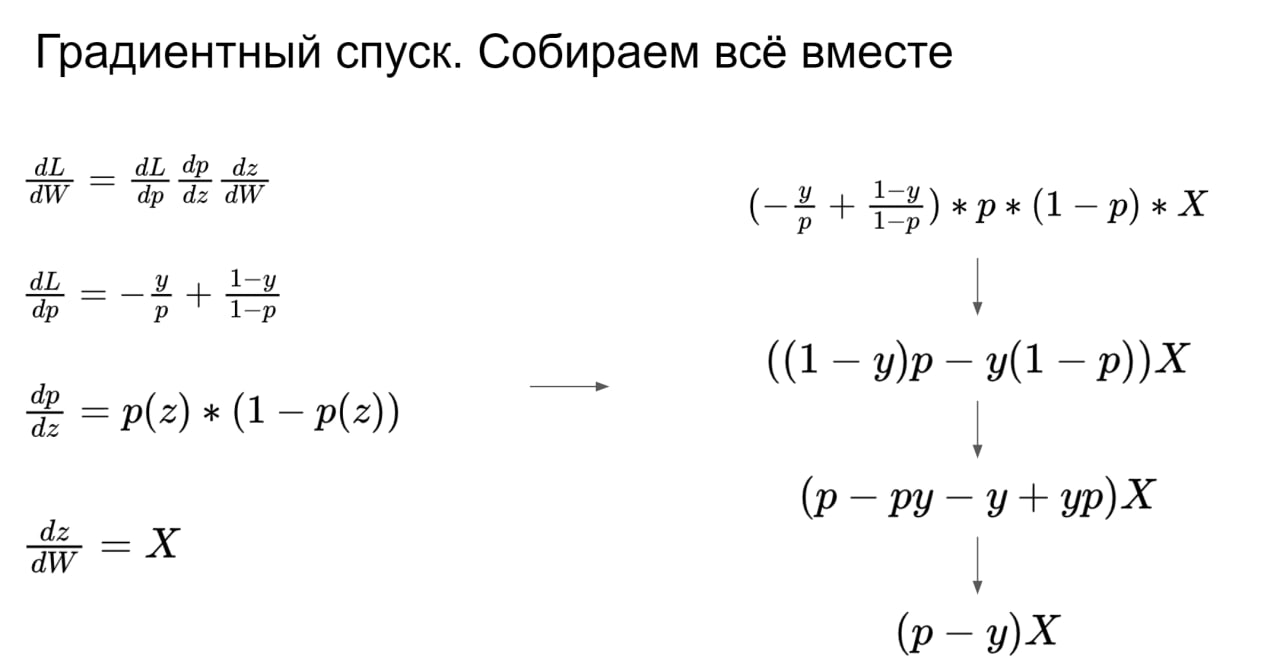

In [ ]:
class MyGBDTClassifier:
  def __init__(self, num_trees=100, max_depth=5, lr=0.5):
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.lr = lr

  def fit(self, X, y):
    self.trees = []

    # Будем складывать сюда ответы
    predicts = np.zeros(y.shape[0])

    for i in range(self.num_trees):
      tree = DecisionTreeRegressor(max_depth=self.max_depth)

      # Добавляем переход из logit в proba
      proba = sigmoid(predicts)

      # Градиент для каждого наблюдения
      new_target = y - proba
      tree.fit(X, new_target)

      self.trees.append(tree)

      tree_predict = tree.predict(X)
      predicts += self.lr * tree_predict

  def predict_proba(self, X):
    logits = np.zeros(X.shape[0])
    for i, tree in enumerate(self.trees):
      logits += self.lr * tree.predict(X)

    proba = sigmoid(logits)

    return np.vstack([1.0-proba, proba]).T

In [ ]:
gb_clf = MyGBDTClassifier()
fit_clf(gb_clf, 'gb_clf')

Train:
ROC AUC: 0.909
Log Loss: 0.298

Test:
ROC AUC: 0.894
Log Loss: 0.321


### LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=100, max_depth=5)
fit_clf(lgbm_clf, 'lgbm_clf')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 7539, number of negative: 26211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 33750, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223378 -> initscore=-1.246090
[LightGBM] [Info] Start training from score -1.246090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train:
ROC AUC: 0.91
Log Loss: 0.299

Test:
ROC AUC: 0.895
Log Loss: 0.319


### CatBoost

In [ ]:
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(n_estimators=100, max_depth=5)
fit_clf(cb_clf, 'cb_clf')

Learning rate set to 0.38239
0:	learn: 0.5235760	total: 6.22ms	remaining: 616ms
1:	learn: 0.4469522	total: 10.6ms	remaining: 519ms
2:	learn: 0.4026495	total: 15.1ms	remaining: 487ms
3:	learn: 0.3790367	total: 19.3ms	remaining: 464ms
4:	learn: 0.3654029	total: 23.6ms	remaining: 448ms
5:	learn: 0.3579550	total: 28ms	remaining: 439ms
6:	learn: 0.3539997	total: 32.6ms	remaining: 433ms
7:	learn: 0.3501107	total: 37.1ms	remaining: 427ms
8:	learn: 0.3478410	total: 41.5ms	remaining: 419ms
9:	learn: 0.3461977	total: 46ms	remaining: 414ms
10:	learn: 0.3441372	total: 50.5ms	remaining: 408ms
11:	learn: 0.3427910	total: 55.1ms	remaining: 404ms
12:	learn: 0.3413980	total: 59.7ms	remaining: 400ms
13:	learn: 0.3402923	total: 64.1ms	remaining: 394ms
14:	learn: 0.3398230	total: 68.6ms	remaining: 389ms
15:	learn: 0.3393891	total: 72.9ms	remaining: 383ms
16:	learn: 0.3386401	total: 77.4ms	remaining: 378ms
17:	learn: 0.3376564	total: 81.9ms	remaining: 373ms
18:	learn: 0.3372511	total: 86.3ms	remaining: 368

### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
fit_clf(lr, 'logistic')

Train:
ROC AUC: 0.81
Log Loss: 0.424

Test:
ROC AUC: 0.814
Log Loss: 0.415


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Попробуем использовать категориальные признаки

In [ ]:
X_train = train[categorical_features]
X_test = test[categorical_features]

In [ ]:
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

<ipython-input-90-e15b4d4f0e89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype('category')
<ipython-input-90-e15b4d4f0e89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_features] = X_test[categorical_features].astype('category')


### LightGBM

In [ ]:
lgbm_clf = LGBMClassifier()
fit_clf(lgbm_clf, 'lgbm_clf_cat_only', values=False)

[LightGBM] [Info] Number of positive: 7539, number of negative: 26211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 33750, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223378 -> initscore=-1.246090
[LightGBM] [Info] Start training from score -1.246090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train:
ROC AUC: 0.897
Log Loss: 0.304

Test:
ROC AUC: 0.9
Log Loss: 0.299


### CatBoost

In [ ]:
cb_clf = CatBoostClassifier()
fit_clf(cb_clf, 'cb_clf_cat_only', values=False)

Learning rate set to 0.046292
0:	learn: 0.5981829	total: 29.4ms	remaining: 29.4s
1:	learn: 0.5236802	total: 55.6ms	remaining: 27.8s
2:	learn: 0.4699546	total: 75.2ms	remaining: 25s
3:	learn: 0.4316259	total: 101ms	remaining: 25.1s
4:	learn: 0.4053623	total: 128ms	remaining: 25.5s
5:	learn: 0.3847056	total: 151ms	remaining: 25.1s
6:	learn: 0.3696520	total: 178ms	remaining: 25.2s
7:	learn: 0.3585225	total: 205ms	remaining: 25.4s
8:	learn: 0.3503580	total: 234ms	remaining: 25.7s
9:	learn: 0.3437944	total: 258ms	remaining: 25.6s
10:	learn: 0.3386990	total: 284ms	remaining: 25.5s
11:	learn: 0.3345743	total: 310ms	remaining: 25.5s
12:	learn: 0.3310699	total: 338ms	remaining: 25.7s
13:	learn: 0.3282725	total: 362ms	remaining: 25.5s
14:	learn: 0.3258268	total: 398ms	remaining: 26.1s
15:	learn: 0.3237852	total: 441ms	remaining: 27.1s
16:	learn: 0.3220348	total: 489ms	remaining: 28.3s
17:	learn: 0.3205321	total: 539ms	remaining: 29.4s
18:	learn: 0.3192223	total: 589ms	remaining: 30.4s
19:	learn:

## Попробуем смешать и категориальные и числовые признаки

In [ ]:
X_train = train[numeric_features + categorical_features]
X_test = test[numeric_features + categorical_features]

In [ ]:
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

<ipython-input-94-e15b4d4f0e89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_features] = X_train[categorical_features].astype('category')
<ipython-input-94-e15b4d4f0e89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_features] = X_test[categorical_features].astype('category')


### LightGBM

In [ ]:
lgbm_clf = LGBMClassifier()
fit_clf(lgbm_clf, 'lgbm_clf_cat_and_num', values=False)

[LightGBM] [Info] Number of positive: 7539, number of negative: 26211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1223
[LightGBM] [Info] Number of data points in the train set: 33750, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223378 -> initscore=-1.246090
[LightGBM] [Info] Start training from score -1.246090
Train:
ROC AUC: 0.988
Log Loss: 0.124

Test:
ROC AUC: 0.98
Log Loss: 0.144


### CatBoost

In [ ]:
cb_clf = CatBoostClassifier()
fit_clf(cb_clf, 'cb_clf_cat_and_num', values=False)

Learning rate set to 0.046292
0:	learn: 0.5872339	total: 45.6ms	remaining: 45.5s
1:	learn: 0.5101402	total: 86.3ms	remaining: 43s
2:	learn: 0.4487523	total: 123ms	remaining: 40.9s
3:	learn: 0.4015159	total: 162ms	remaining: 40.4s
4:	learn: 0.3628570	total: 203ms	remaining: 40.3s
5:	learn: 0.3331829	total: 247ms	remaining: 40.9s
6:	learn: 0.3114675	total: 286ms	remaining: 40.6s
7:	learn: 0.2928719	total: 327ms	remaining: 40.6s
8:	learn: 0.2798342	total: 367ms	remaining: 40.5s
9:	learn: 0.2698058	total: 409ms	remaining: 40.5s
10:	learn: 0.2601966	total: 450ms	remaining: 40.4s
11:	learn: 0.2531532	total: 488ms	remaining: 40.1s
12:	learn: 0.2464496	total: 530ms	remaining: 40.2s
13:	learn: 0.2414626	total: 573ms	remaining: 40.4s
14:	learn: 0.2370527	total: 614ms	remaining: 40.3s
15:	learn: 0.2325576	total: 654ms	remaining: 40.3s
16:	learn: 0.2294515	total: 694ms	remaining: 40.2s
17:	learn: 0.2262624	total: 735ms	remaining: 40.1s
18:	learn: 0.2234772	total: 776ms	remaining: 40.1s
19:	learn: 

## Сравнение

In [ ]:
pd.DataFrame(global_classification_metrics).T

,train_roc_auc,train_log_loss,test_roc_auc,test_log_loss
gb_clf,0.909,0.298,0.894,0.321
lgbm_clf,0.910,0.299,0.895,0.319
cb_clf,0.902,0.307,0.893,0.320
logistic,0.810,0.424,0.814,0.415
lgbm_clf_cat_only,0.897,0.304,0.900,0.299
cb_clf_cat_only,0.896,0.306,0.902,0.298
lgbm_clf_cat_and_num,0.988,0.124,0.980,0.144
cb_clf_cat_and_num,0.987,0.123,0.979,0.146


# Feature Importance(Важность Признаков)

In [ ]:
import lightgbm

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

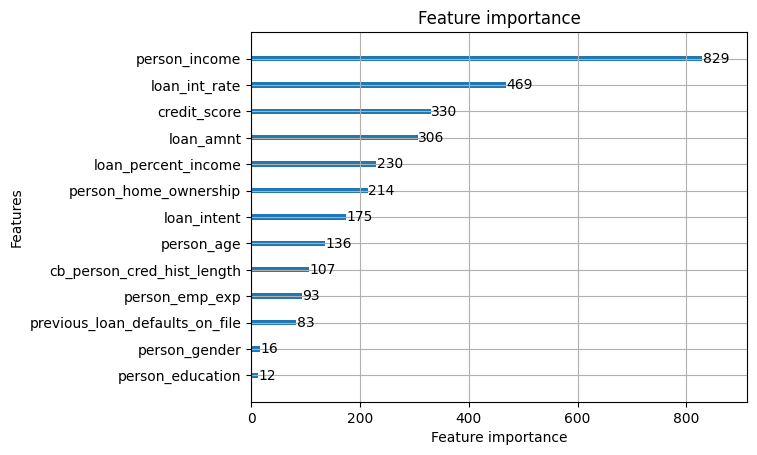

In [ ]:
lightgbm.plot_importance(lgbm_clf)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

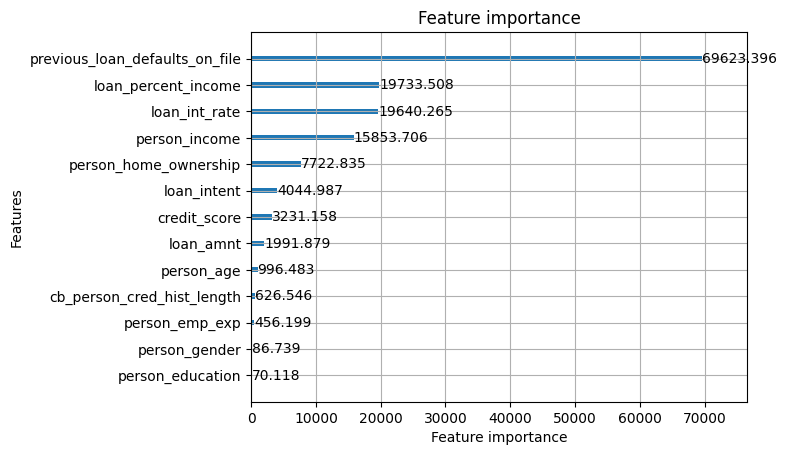

In [ ]:
lightgbm.plot_importance(lgbm_clf, importance_type='gain')

**коррелирующие признаки могут снизить importance для модели**

Оценим каждую фичу в отдельности (можно и не строя модель)

In [ ]:
def gini(y_true, score):
  return 2 * roc_auc_score(y_true, score) - 1

In [ ]:
stats = []
for feature in numeric_features:
  stats.append({
      'feature': feature,
      'gini': abs(gini(y_train, X_train[feature]))
  })
stats = pd.DataFrame(stats)
display(stats.sort_values('gini'))

### Permutation Importance

На обученной модели берём конкретную фичу и делаем shuffle значений внутри выборки, то есть у конкретного наблюдение будет не его корректное значение фичи, а чье-то другое.

Мы сохраняе распределение фичи на уровне выборки, но при этом ломаем связь между фичей и наблюдением.

Смотрим как изменяются метрики - сильно значит модель сильно опирается на эту фичу, если почти не изменяются - возможно модель почти не смотрит на этй фичу

### Propensity Score

Оценка стабильности фичей с помощью Propensity Score.

Смешиваем Train/Test выборки, добавляя бинарный флаг (1 если наблюдение из Train, 0 иначе)

Строим модель на фичах, которая предсказывает этот флаг. Если имеем хорошее качество - выборки почему-то отличаются, можно посмотреть на feature importance модели, чтобы понять на какие фичи она в основном опиралас - скорее всего их распределение отличается между выборками (если Test - Out of Time, это может говорить о Data Drift)

## ДЗ
Добавить в Random Forest и Gradient Boosting выбор случайного набора фичей для построения каждого отдельного дерева.

**Необходимо** использовать реализованные деревья из прошлой домашки (реализовать для задачи регрессии)



In [ ]:
class MyRandomForestRegressor:
  def __init__(self, num_trees=10, max_depth=5, features_by_tree_strategy='sqrt'):
    '''
    features_by_tree_strategy - всего 3 варианта: half, sqrt и other
    '''
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.features_by_tree_strategy = features_by_tree_strategy # Запомним стратегию выбора фией

  def fit(self, X, y):
    # Создаем массив деревьев куда будем складывать обученные деревья
    self.trees = []

    # Кол-во фичей
    n_cols = X.shape[1]

    # В зависимости от стратегии использования фичей ограничиваем максимальное кол-во фичей для каждого дерева
    if self.features_by_tree_strategy == 'sqrt':
      # Не больше корня от кол-ва фичей
      n_cols_by_tree = int(np.ceil(n_cols**0.5))
    elif self.features_by_tree_strategy == 'half':
      # Не больше половины от кол-ва фичей
      n_cols_by_tree = int(np.ceil(n_cols*0.5))
    else:
      # Все фичи
      n_cols_by_tree = n_cols

    # Строим деревья
    for i in range(self.num_trees):
      ... # Написать свой код

  def predict(self, X):
    # Будем складывать сюда предикты
    predicts = []

    # Пробегаемся по деревьем и считаем их предикты
    for i, tree in enumerate(self.trees):
      ... # Написать свой код

    # Усредняем ответы деревьев для каждого наблюдения
    answer = np.mean(predicts, axis=0)
    return answer

Тоже самое сделать для бустинга

In [ ]:
class MyGBDTRegressor:
  def __init__(self, num_trees=100, max_depth=5, lr=0.5, features_by_tree_strategy='sqrt'):
    ... # написать свой код

  def fit(self, X, y):
    ... # написать свой код

  def predict(self, X):
   ... # написать свой код

Сравнить результаты от изменения параметра - кол-во фичей для построения дерева. Сравнить с RandomForestRegressor из scikit-learn.